# Изтегляме някой необходими библиотеки

In [16]:
! pip install pandas
! pip install torch
! pip install transformers
! pip install tensorflow

In [3]:
import os
import pandas as pd
import torch.nn as nn
from transformers import  BertModel, BertTokenizer, BertConfig, TFBertModel
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset
import tensorflow.keras.backend as K 
from tensorflow.keras.layers import Dense, Input, Dropout,Embedding, GlobalAvgPool1D
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Model
import tensorflow.keras.backend as K
from keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

# NAh loading

In [4]:
train_dataset = pd.read_csv('train_dataset.csv').head(50)
test_dataset = pd.read_csv('test_dataset.csv').head(50)

In [5]:
train_dataset.columns = ['Prediction Label','Title','Content']
test_dataset.columns = ['Prediction Label','Title','Content']


train_dataset.head(15)

,Prediction Label,Title,Content
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...
5,1,Buyer beware,"This is a self-published book, and if you want..."
6,2,Glorious story,I loved Whisper of the wicked saints. The stor...
7,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
8,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...
9,1,The Worst!,A complete waste of time. Typographical errors...


In [6]:
#Configs 
MAX_SEQUENCE_LENGTH = 300
TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
EPOCHS = 2

In [7]:
#function to convert text into suitable Bert input form
def get_model_inputs(str1, str2, _truncation_strategy, length, tokenizer, pad_seq = True):
    #print(str1)
    #print(str2)
    inputs = tokenizer.encode_plus(str1,
                                    str2,
                                    add_special_tokens=True,
                                    max_length=length,
                                    truncation_strategy=_truncation_strategy,
                                    pad_to_max_length=pad_seq)

    input_ids = inputs["input_ids"]
    input_masks = inputs["attention_mask"]
    input_segments = inputs["token_type_ids"]
    return [input_ids, input_masks, input_segments]

In [14]:
def datagen(dataset, batch_size):
  data = dataset.copy()
  data_len = len(data.index)
  #print(data_len)
  #print(batch_size)
  #print(int(data_len/batch_size))
  # Initialize tokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  while True:
    for i in range(int(data_len/batch_size)):
      inputs_x_id, inputs_x_mask, inputs_x_segment, inputs_y = [], [], [], []
      start = i*batch_size
      end = start+batch_size
      #print(start)
      #print(end)
      batch_x = data.iloc[start:end,1].values
      batch_y = data.iloc[start:end,2].values
      batch_z = data.iloc[start:end,0].values
      
      for i in range(batch_size):
        input_ids, input_masks, input_segments = get_model_inputs(batch_x[i], batch_y[i], 
                                                                  True, 
                                                                  MAX_SEQUENCE_LENGTH, 
                                                                  tokenizer)
        
        inputs_x_id.append(input_ids)
        inputs_x_mask.append(input_masks)
        inputs_x_segment.append(input_segments)
        inputs_y.append(batch_z[i])
      yield ([np.array(inputs_x_id, dtype=np.int32),
             np.array(inputs_x_mask, dtype=np.int32),
             np.array(inputs_x_segment, dtype=np.int32)],
             np.array(inputs_y, dtype=np.int32))

K.clear_session()
train_data_generator = datagen(train_dataset, TRAIN_BATCH_SIZE)
test_data_generator = datagen(test_dataset, TEST_BATCH_SIZE)

In [9]:
def create_model():
    input_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    input_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    input_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    input_embedding = bert_model(input_id, attention_mask=input_mask, token_type_ids=input_atn)[0]

    # Get average tokens output
    tokens_embedding = tf.keras.layers.GlobalAveragePooling1D()(input_embedding)
    
    x = tf.keras.layers.Dense(128, activation='relu')(tokens_embedding)
        
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[input_id, input_mask, input_atn], outputs=x)
    
    return model

bert = create_model();

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:


#loss function (modified binary cross entropy loss function which gives higher attention to misclassified examples)
def focal_loss(y_true, y_pred, gamma=2., alpha=.25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))



In [11]:


early_stopping = EarlyStopping(monitor= 'val_acc', 
                               mode = 'max',
                               patience=30, 
                               verbose=1)

model_checkpoint = ModelCheckpoint('BERT_MODEL_AMAZON_REVIEW_CLASSIFIER',
                                   monitor = 'val_acc', 
                                   mode = 'max', 
                                   save_best_only=True, 
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                              mode = 'max',
                              factor=0.2, 
                              patience=4, 
                              min_lr=0.0000001, 
                              verbose=1)
opt = Adam(learning_rate = 0.0005)
bert.compile(loss = focal_loss, optimizer= opt, metrics=['acc'])



In [15]:
#train the model
history = bert.fit_generator(generator=train_data_generator,
                    validation_data=test_data_generator,
                    steps_per_epoch = len(train_dataset)//TRAIN_BATCH_SIZE,
                    validation_steps = len(test_dataset)//TEST_BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = [early_stopping, model_checkpoint, reduce_lr])

C:\Users\Simona\AppData\Local\Temp\ipykernel_6140\550918866.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = bert.fit_generator(generator=train_data_generator,


50
10
5
range(1, 5)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0
10
Epoch 1/2
10
20
1/5 [=====>........................] - ETA: 1:20 - loss: 2.8168e-15 - acc: 0.200020
30
2/5 [===========>..................] - ETA: 44s - loss: 1.4626e-15 - acc: 0.3500 30
40
3/5 [=================>............] - ETA: 31s - loss: 1.0060e-15 - acc: 0.433340
50
4/5 [=======================>......] - ETA: 15s - loss: 8.0351e-16 - acc: 0.47500
10
5/5 [==============================] - ETA: 0s - loss: 6.4736e-16 - acc: 0.4600 50
10
5
range(1, 5)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0
10
10
20
20
30
30
40
40
50
0
10

Epoch 1: val_acc did not improve from 0.44000
5/5 [==============================] - 113s 23s/step - loss: 6.4736e-16 - acc: 0.4600 - val_loss: 4.0337e-18 - val_acc: 0.4400 - lr: 5.0000e-04
Epoch 2/2
10
20
1/5 [=====>........................] - ETA: 1:10 - loss: 5.5678e-16 - acc: 0.200020
30
2/5 [===========>..................] - ETA: 53s - loss: 2.8881e-16 - acc: 0.3500 30
40
3/5 [=================>............] - ETA: 36s - loss: 8.4040e-16 - acc: 0.433340
50
4/5 [=======================>......] - ETA: 18s - loss: 1.5732e-15 - acc: 0.47500
10
5/5 [==============================] - ETA: 0s - loss: 1.2771e-15 - acc: 0.4600 10
20
20
30
30
40
40
50
0
10
10
20

Epoch 2: val_acc did not improve from 0.44000
5/5 [==============================] - 130s 28s/step - loss: 1.2771e-15 - acc: 0.4600 - val_loss: 1.8635e-18 - val_acc: 0.4400 - lr: 5.0000e-04


dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


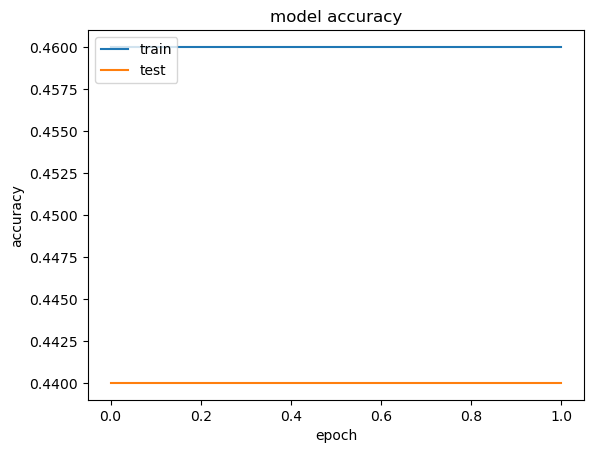

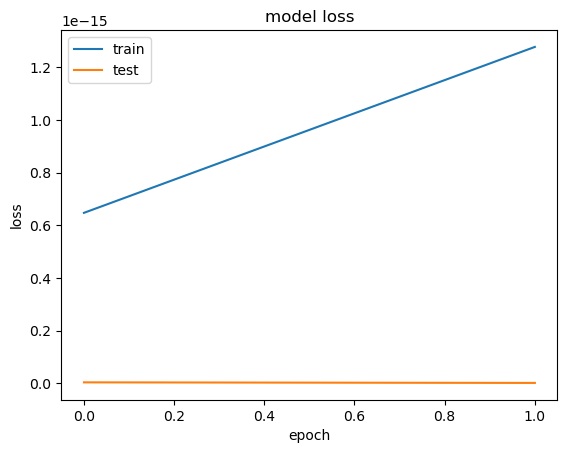

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()